# Building out the CTD network

We've downloaded the files from CTD.  Some contain node to node relationships, others contian information about the nodes including identifiers and hierarchial structures.  We will use these data to build a node and edges file that can be imported into neo4j

In [1]:
# python package imports
import numpy as np
import pandas as pd
from pathlib import Path
from copy import deepcopy                                                                                               
from itertools import chain                                                                                             
from collections import defaultdict

import data_tools.graphs as gt
from data_tools import df_processing as pr

from tools.hetnet_file_processing import read_ctd

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
file_info = pd.read_csv('../0_data/manual/edge_file_info.csv')
load_dir = Path('../2_pipeline/00_download_data/out/').resolve()

In [3]:
id_files = file_info.query('file_source == "CTD" and file_type == "ids"').set_index('source_type')

# Nodes

In [4]:
nodes = list()

### Compounds

In [5]:
compound_info = read_ctd(load_dir.joinpath(id_files.loc['Compound', 'file_name']))
compound_info.head(2)

,chemical_name,chemical_id,cas_rn,definition,parent_ids,tree_numbers,parent_tree_numbers,synonyms,drug_bank_ids
0,(0.017ferrocene)amylose,MESH:C089250,NaN,NaN,MESH:D000688|MESH:D005296,D01.490.200/C089250|D02.691.550.200/C089250|D0...,D01.490.200|D02.691.550.200|D09.301.915.361|D0...,(0.017 ferrocene)amylose,NaN
1,001-C8-NBD,MESH:C114385,NaN,NaN,MESH:D009842|MESH:D010069,D03.383.129.462.580/C114385|D12.644.456/C114385,D03.383.129.462.580|D12.644.456,001 C8 NBD|H-MeTyr-Arg-MeArg-D-Leu-NH(CH2)8NH-...,NaN


ID and name are required for making a node file.  We will use the parent IDs to make a tree of the hierarchy, to better mapping of edges.  Finally, keeping info like tree numbers and any xrefs (like drugbank) will be useful for future network joining and analysis of compound classes.

In [6]:
comp_nodes = compound_info[['chemical_id', 'chemical_name', 'tree_numbers', 'drug_bank_ids']]
comp_nodes = comp_nodes.rename(columns={'chemical_id': 'id', 'chemical_name': 'name'})
comp_nodes['label'] = 'Compound'

comp_nodes.head(5)

,id,name,tree_numbers,drug_bank_ids,label
0,MESH:C089250,(0.017ferrocene)amylose,D01.490.200/C089250|D02.691.550.200/C089250|D0...,NaN,Compound
1,MESH:C114385,001-C8-NBD,D03.383.129.462.580/C114385|D12.644.456/C114385,NaN,Compound
2,MESH:C114386,001-C8 oligopeptide,D12.644.456/C114386,NaN,Compound
3,MESH:C434150,"0231A , Streptomyces",D03.633.400/C434150,NaN,Compound
4,MESH:C434149,"0231B, Streptomyces",D03.633.400/C434149,NaN,Compound


In [7]:
nodes.append(comp_nodes)

In [8]:
def get_parent_to_child_map(df, parent_col, child_col, sep='|', verbose=False):                                         
    """                                                                                                                 
    Gets a map from the parent ID to IDs of all children (and children of children etc.)                                
    Source dataframe (EG, CTD)                                                                                          
    """                                                                                                                 
    # Initialize the map                                                                                                
    par_to_children = defaultdict(set)                                                                                  
    expanded = pr.expand_col_on_char(df.dropna(subset=[parent_col]), parent_col, sep)                                      
                                                                                                                        
    # Get mappings from child to local parents                                                                          
    for row in expanded.itertuples():                                                                                   
        par_to_children[getattr(row, parent_col)].add(getattr(row, child_col))                                          
                                                                                                                        
    # Extend the map... parents map to local children, but need mapping to the children of children, too                
    par_to_children = extend_map(par_to_children, verbose)                                                              
                                                                                                                        
    # Discard empty values (default_dict will add an empty one when simply accessed)                                    
    par_to_children = {k: v for k, v in par_to_children.items() if len(v) > 0}                                          
                                                                                                                        
    return par_to_children   


def extend_map(mapper, verbose=False):                                                                                  
    """                                                                                                                 
    Takes a dict mapper of a tree (e.g. parents to children) a extends down so parents map to all                       
    intermediate children, terminating at a leaf.                                                                       
    """                                                                                                                 
                                                                                                                        
    prev_total_mappings = 0                                                                                             
    total_mappings = len(list(chain(*mapper.values())))                                                                 
    num_iter = 0                                                                                                        
    i = 0                                                                                                               
                                                                                                                        
    while (total_mappings != prev_total_mappings):                                                                      
        prev_total_mappings = len(list(chain(*mapper.values())))                                                        
        current_map = deepcopy(mapper)                                                                                  
        for k, v in current_map.items():                                                                                
            for val in v:                                                                                               
                mapper[k].update(mapper[val])                                                                           
        total_mappings = len(list(chain(*mapper.values())))                                                             
                                                                                                                        
                                                                                                                        
        if verbose:                                                                                                     
            num_iter += total_mappings                                                                                  
            # Print an update every 10 Million iterations (approx)                                                      
            if i == 0 or np.floor(num_iter / 1e7) - np.floor((num_iter - total_mappings) / 1e7) > 0:                    
                print('Iter: {}, Total Mappings: {:,}'.format(i, total_mappings))                                       
        i += 1                                                                                                          
                                                                                                                        
    return mapper 


def make_child_to_root_map(df, parent_col, child_col, sep='|', verbose=False):                                          
    """                                                                                                                 
    In a dataframe where one column is child identfiers, and another parent,                                            
    creates a map from child to root.                                                                                   
    """                                                                                                                 
                                                                                                                        
    root_concepts = df[df[parent_col].isnull()][child_col].tolist()                                                     
    parent_to_child = get_parent_to_child_map(df, parent_col, child_col, sep, verbose)                                  
                                                                                                                        
    child_to_parent = dict()                                                                                            
                                                                                                                        
    for k, v in parent_to_child.items():                                                                                
        for val in v:                                                                                                   
            if k in root_concepts:                                                                                      
                child_to_parent[val] = k                                                                                
                                                                                                                        
    for r in root_concepts:                                                                                             
        child_to_parent[r] = r                                                                                          
                                                                                                                        
    return child_to_parent 


def convert_abbrev_mapper_to_full(mapper, map_df, abbrev, full):                                                        
    """                                                                                                                 
    With a mapping file from abbrev to abbrev, and a datafame that has abbrev to full mappings, produces                
    a mapper from full to full.                                                                                         
    """                                                                                                                 
    abbrev_to_name = map_df.set_index(abbrev)[full].to_dict()                                                           
    return {abbrev_to_name[k]: abbrev_to_name[v] for k, v in mapper.items()}  


def prepend_direction_to_map(mapper, directions=iter(()), char=''):                                                     
    """                                                                                                                 
    In a dict, will prepend all elements of `directions` to all keys and values, sparated by `char`                     
                                                                                                                        
    e.g. a dict of  {'metabolic processing': 'metabolic processing',                                                    
                     'acetylation': 'metabolic processing'}                                                             
    And directions ['increasing', 'decreasing'] with char '^'                                                           
                                                                                                                        
    becomes:                                                                                                            
         {'increases^metabolic processing': 'increases^metabolic processing',                                           
          'increases^acetylation': 'increases^metabolic processing',                                                    
          'decreases^metabolic processing': 'decreases^metabolic processing',                                           
          'decreases^acetylation': 'decreases^metabolic processing'}                                                    
    """                                                                                                                 
    out_map = dict()                                                                                                    
    for k, v in mapper.items():                                                                                         
        for d in directions:                                                                                            
            new_k = d+char+k                                                                                            
            new_v = d+char+v                                                                                            
            out_map[new_k] = new_v                                                                                      
    return out_map 

In [9]:
comp_p2c = get_parent_to_child_map(compound_info, 'parent_ids', 'chemical_id')

In [10]:
type(comp_nodes) == pd.DataFrame

True

In [11]:
def test_parent_child(pc_info, node_df, parent_2_child_map, idx=0):

    if type(pc_info) == pd.DataFrame:        
        test_id = pc_info.dropna(subset=['parent_ids']).iloc[idx]['parent_ids'].split('|')[0]
    elif type(pc_info) == str:
        test_id = pc_info
    node_df = node_df.set_index('id')
    print('Parent: {}'.format(node_df.loc[test_id, 'name']))
    print('Children:')
    for child in parent_2_child_map[test_id]:
        print('\t{}'.format(node_df.loc[child, 'name']))


In [12]:
test_parent_child(compound_info, comp_nodes, comp_p2c)

Parent: Amylose
Children:
	Cibacron Blue F 3GA-amylose
	thymol amylose
	amylose-tris-(5-chloro-2-methylphenylcarbamate)
	(0.017ferrocene)amylose
	6-deoxyamylose
	Cibacron Blue-amylose
	sodium amylose succinate
	amylose triacetate
	amylose tris(n-hexylcarbamate)
	Chiralpak AD
	oxyamylose
	amylose tris(1-phenylethylcarbamate)
	amylose tris(ethylcarbamate)
	amylose-2-acetyl-3,6-bis(phenylcarbamate)
	chiralpak AS
	carboxymethylamylose
	amylose tri(3,5-dimethyl carbamate)


### Diseases

In [13]:
disease_info = read_ctd(load_dir.joinpath(id_files.loc['Disease', 'file_name']))
disease_info.head(2)

,disease_name,disease_id,alt_disease_ids,definition,parent_ids,tree_numbers,parent_tree_numbers,synonyms,slim_mappings
0,10p Deletion Syndrome (Partial),MESH:C538288,NaN,NaN,MESH:D002872|MESH:D025063,C16.131.260/C538288|C16.320.180/C538288|C23.55...,C16.131.260|C16.320.180|C23.550.210.050.500.500,"Chromosome 10, 10p- Partial|Chromosome 10, mon...",Congenital abnormality|Genetic disease (inborn...
1,13q deletion syndrome,MESH:C535484,NaN,NaN,MESH:D002872|MESH:D025063,C16.131.260/C535484|C16.320.180/C535484|C23.55...,C16.131.260|C16.320.180|C23.550.210.050.500.500,Chromosome 13q deletion|Chromosome 13q deletio...,Congenital abnormality|Genetic disease (inborn...


In [14]:
dis_nodes = disease_info[['disease_id', 'disease_name', 'tree_numbers', 'alt_disease_ids']]
dis_nodes = dis_nodes.rename(columns={'disease_id': 'id', 'disease_name': 'name'})
dis_nodes['label'] = 'Disease'

dis_nodes.head(5)

,id,name,tree_numbers,alt_disease_ids,label
0,MESH:C538288,10p Deletion Syndrome (Partial),C16.131.260/C538288|C16.320.180/C538288|C23.55...,NaN,Disease
1,MESH:C535484,13q deletion syndrome,C16.131.260/C535484|C16.320.180/C535484|C23.55...,NaN,Disease
2,MESH:C579849,15q24 Microdeletion,C10.597.606.360/C579849|C16.131.260/C579849|C1...,DO:DOID:0060395,Disease
3,MESH:C579850,16p11.2 Deletion Syndrome,C10.597.606.360/C579850|C16.131.260/C579850|C1...,NaN,Disease
4,MESH:C567076,"17,20-Lyase Deficiency, Isolated",C12.706.316.090.500/C567076|C13.351.875.253.09...,NaN,Disease


In [15]:
nodes.append(dis_nodes)

In [16]:
dis_p2c_map = get_parent_to_child_map(disease_info, 'parent_ids', 'disease_id')

In [17]:
# IDX 0 == chromoasome deletion with too many children to print nicely
test_parent_child(disease_info, dis_nodes, dis_p2c_map, idx=20)

Parent: Urea Cycle Disorders, Inborn
Children:
	N-acetyl glutamate synthetase deficiency
	Citrullinemia
	HHH syndrome
	Argininosuccinic Aciduria
	Adult-onset citrullinemia type 2
	3-methylcrotonyl CoA carboxylase 1 deficiency
	Hyperargininemia
	Ornithine Carbamoyltransferase Deficiency Disease
	Neonatal-onset citrullinemia type 2
	ORNITHINE TRANSCARBAMYLASE DEFICIENCY, HYPERAMMONEMIA DUE TO
	Osteopetrosis with renal tubular acidosis
	3-methylcrotonyl CoA carboxylase 2 deficiency
	Citrulline transport defect
	Carbamoyl-Phosphate Synthase I Deficiency Disease
	CTNL1


### Genes

In [18]:
gene_info = read_ctd(load_dir.joinpath(id_files.loc['Gene', 'file_name']))
gene_info.head(2)

,gene_symbol,gene_name,gene_id,alt_gene_ids,synonyms,bio_gridids,pharm_gkbids,uni_prot_ids
0,03B03F,"DNA segment, 03B03F (Research Genetics)",27777,NaN,NaN,NaN,NaN,NaN
1,03B03R,"DNA segment, 03B03R (Research Genetics)",27778,NaN,NaN,NaN,NaN,NaN


Both Gene symbol and Gene ID could be use as identifiers... we also want all the other ids, too.. No parent-child relationships to worry about here.

In [19]:
gene_nodes = gene_info[['gene_id', 'gene_name', 'gene_symbol', 'alt_gene_ids', 'bio_gridids', 'pharm_gkbids', 'uni_prot_ids']]
gene_nodes = gene_nodes.rename(columns={'gene_id': 'id', 'gene_name': 'name'})
gene_nodes['id'] = 'NCBIGene:' + gene_nodes['id'].astype(str)
gene_nodes['gene_symbol'] = 'SYM:' + gene_nodes['gene_symbol']

gene_nodes['label'] = 'Gene'

gene_nodes.head(5)

,id,name,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,label
0,NCBIGene:27777,"DNA segment, 03B03F (Research Genetics)",SYM:03B03F,NaN,NaN,NaN,NaN,Gene
1,NCBIGene:27778,"DNA segment, 03B03R (Research Genetics)",SYM:03B03R,NaN,NaN,NaN,NaN,Gene
2,NCBIGene:53288,"DNA segment, 03.MMHAP34FRA.seq",SYM:03.MMHAP34FRA.SEQ,NaN,NaN,NaN,NaN,Gene
3,NCBIGene:5658107,NaN,SYM:064YA,NaN,NaN,NaN,NaN,Gene
4,NCBIGene:56573,"DNA segment, 102g4T7",SYM:102G4T7,NaN,NaN,NaN,NaN,Gene


In [20]:
nodes.append(gene_nodes)

### Pathways

In [21]:
pathway_info = read_ctd(load_dir.joinpath(id_files.loc['Pathway', 'file_name']))
pathway_info.head(2)

,pathway_name,pathway_id
0,2-LTR circle formation,REACT:R-HSA-164843
1,2-Oxocarboxylic acid metabolism,KEGG:hsa01210


This is about as simple as it can be, just take ids and names

In [22]:
pw_nodes = pathway_info[['pathway_id', 'pathway_name']].copy()
pw_nodes.columns = [c.split('_')[-1] for c in pw_nodes.columns]
pw_nodes['label'] = 'Pathway'

pw_nodes.head(5)

,id,name,label
0,REACT:R-HSA-164843,2-LTR circle formation,Pathway
1,KEGG:hsa01210,2-Oxocarboxylic acid metabolism,Pathway
2,REACT:R-HSA-73843,5-Phosphoribose 1-diphosphate biosynthesis,Pathway
3,REACT:R-HSA-2161541,Abacavir metabolism,Pathway
4,REACT:R-HSA-2161517,Abacavir transmembrane transport,Pathway


In [23]:
nodes.append(pw_nodes)

## What other nodes do we need info on?

In [24]:
set(file_info.query('file_source == "CTD"')[['source_type', 'target_type']].stack()) - \
        set([n.loc[0,'label'] for n in nodes])


{'Biological Process',
 'Cellular Component',
 'GO Term',
 'Molecular Function',
 'relationships'}

All are GO Term related, so best practice to use GO Ontology to sort out relationships

In [25]:
import obonet
import networkx as nx

In [26]:
go_file = file_info.query('file_source == "go"').iloc[0,0]
go = obonet.read_obo(load_dir.joinpath(go_file))

In [27]:
go_nodes = dict()
go_nodes['id'] = [g for g in go]
go_nodes['name'] = [info['name'] for nid, info in go.nodes(data=True)]
go_nodes['label'] = [info['namespace'] for nid, info in go.nodes(data=True)]

go_nodes = pd.DataFrame(go_nodes)
go_nodes['label'] = go_nodes['label'].str.replace('_', ' ').str.title()
go_nodes.head(5)

,id,name,label
0,GO:0000001,mitochondrion inheritance,Biological Process
1,GO:0000002,mitochondrial genome maintenance,Biological Process
2,GO:0000003,reproduction,Biological Process
3,GO:0000006,high-affinity zinc transmembrane transporter a...,Molecular Function
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,Molecular Function


In [28]:
nodes.append(go_nodes)

In [29]:
# Networkx makes this mapping easy
go_p2c_map = {g: nx.ancestors(go, g) for g in go_nodes['id']}

In [30]:
test_parent_child('GO:0015800', go_nodes, go_p2c_map)

Parent: acidic amino acid transport
Children:
	glutamate reuptake
	L-glutamate import across plasma membrane
	L-glutamate transmembrane transport
	L-glutamate import
	regulation of glutamate secretion
	regulation of aspartate secretion
	negative regulation of L-glutamate import across plasma membrane
	regulation of L-glutamate import across plasma membrane
	positive regulation of glutamate uptake involved in transmission of nerve impulse
	glutamate transmembrane import into vacuole
	gamma-aminobutyric acid import
	negative regulation of glutamate uptake involved in transmission of nerve impulse
	negative regulation of glutamate secretion, neurotransmission
	negative regulation of aspartate secretion
	aspartate secretion, neurotransmission
	L-glutamate import involved in cellular response to nitrogen starvation
	L-glutamate transmembrane import into vacuole
	positive regulation of glutamate neurotransmitter secretion in response to membrane depolarization
	glutamate secretion, neurotran

In [31]:
nodes = pd.concat(nodes, sort=False, ignore_index=True)
len(nodes)

747662

In [32]:
nodes = nodes[sorted(nodes.columns, key=lambda x: x not in ['id', 'name', 'label'])]

In [33]:
nodes.shape

(747662, 11)

# Edges

Need some info about certain types of relationships in this netowrk

In [34]:
edges = list()

In [35]:
rel_info = read_ctd(load_dir.joinpath(id_files.loc['relationships', 'file_name']))

In [36]:
ixn_map_to_par = make_child_to_root_map(rel_info, 'parent_code', 'code', sep='|')
ixn_map_to_par_full = convert_abbrev_mapper_to_full(ixn_map_to_par, rel_info, 'code', 'type_name')

In [37]:
e_files = file_info.query('file_source == "CTD" and file_type == "edges"')['file_name'].tolist()

In [38]:
print(e_files[0])

CTD_chem_gene_ixns.csv.gz


### Chem to Genes

In [39]:
chem_gene = read_ctd(load_dir.joinpath(e_files[0]))
chem_gene.head(2)

,chemical_name,chemical_id,cas_rn,gene_symbol,gene_id,gene_forms,organism,organism_id,interaction,interaction_actions,pub_med_ids
0,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 affects the folding of and results in...,affects^binding|affects^folding|decreases^acti...,26474287
1,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 inhibits the reaction [MYC protein bi...,affects^binding|decreases^reaction,26474287


interaction_actions are pipe, separated... We want those that are unique on their own line. However, the interactions used are a bit too granular, so we also want to map to thier parents.  Finally, we want to keep all PMIDs and organism ids for each interaction for potnetial future use.

In [40]:
chem_gene = pr.expand_col_on_char(chem_gene, 'interaction_actions', '|')
chem_gene.head(5)

,chemical_name,chemical_id,cas_rn,gene_symbol,gene_id,gene_forms,organism,organism_id,interaction,interaction_actions,pub_med_ids
0,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 affects the folding of and results in...,affects^binding,26474287
1,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 affects the folding of and results in...,affects^folding,26474287
2,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 affects the folding of and results in...,decreases^activity,26474287
3,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 inhibits the reaction [MYC protein bi...,affects^binding,26474287
4,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 inhibits the reaction [MYC protein bi...,decreases^reaction,26474287


In [41]:
ixn_dirs = chem_gene['interaction_actions'].str.split('^', expand=True)[0].unique()
ixn_dirs

array(['affects', 'decreases', 'increases'], dtype=object)

In [42]:
directed_ixn_map_to_par_full = prepend_direction_to_map(ixn_map_to_par_full, ixn_dirs, '^')

In [43]:
chem_gene['parent_ixn'] = chem_gene['interaction_actions'].map(directed_ixn_map_to_par_full)
chem_gene.head(5)

,chemical_name,chemical_id,cas_rn,gene_symbol,gene_id,gene_forms,organism,organism_id,interaction,interaction_actions,pub_med_ids,parent_ixn
0,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 affects the folding of and results in...,affects^binding,26474287,affects^binding
1,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 affects the folding of and results in...,affects^folding,26474287,affects^folding
2,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 affects the folding of and results in...,decreases^activity,26474287,decreases^activity
3,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 inhibits the reaction [MYC protein bi...,affects^binding,26474287,affects^binding
4,10074-G5,C534883,NaN,MAX,4149,protein,NaN,NaN,10074-G5 inhibits the reaction [MYC protein bi...,decreases^reaction,26474287,decreases^reaction


In [44]:
# Fix typing on organism IDs as they will be floats...
idx = chem_gene.dropna(subset=['organism_id']).index
chem_gene.loc[idx, 'organism_id'] = chem_gene.loc[idx, 'organism_id'].apply(lambda s: str(int(s)))

In [45]:
chem_gene['chemical_id'] = 'MESH:' + chem_gene['chemical_id']
chem_gene['organism_id'] = 'NCBITaxon:' + chem_gene['organism_id']
chem_gene['gene_id'] = 'NCBIGene:' + chem_gene['gene_id'].astype(str)

In [46]:
%%time
chem_gene = pr.combine_group_cols_on_char(chem_gene, ['chemical_id', 'gene_id', 'parent_ixn'],
                                          ['pub_med_ids', 'organism_id'], sort=True, prog=False)

CPU times: user 1min 24s, sys: 792 ms, total: 1min 24s
Wall time: 1min 24s


In [47]:
cg_edges = chem_gene[['chemical_id', 'gene_id', 'parent_ixn', 'pub_med_ids', 'organism_id']]
cg_edges = cg_edges.rename(columns={'chemical_id': 'start_id', 'gene_id': 'end_id'})

In [48]:
cg_edges['parent_ixn'].value_counts()

increases^expression               479825
decreases^expression               410983
affects^cotreatment                184777
affects^expression                 137093
decreases^reaction                  95223
increases^metabolic processing      66522
affects^binding                     36161
increases^reaction                  30886
increases^activity                  29001
decreases^metabolic processing      28742
decreases^activity                  21926
affects^reaction                    17713
affects^metabolic processing        16070
increases^transport                 12559
affects^response to substance       12279
increases^response to substance      7964
decreases^response to substance      6965
increases^abundance                  6253
affects^localization                 5965
decreases^transport                  2632
affects^activity                     2382
affects^transport                    1700
increases^mutagenesis                1529
decreases^abundance               

Lots of different things here, but basically all we care about is +, -, and general association in terms of activity... for now we will keep a distinction between expression and activity, but these may be merged later.

In [49]:
keep_ixns = [direction+'^expression' for direction in ixn_dirs]
keep_ixns += [direction+'^activity' for direction in ixn_dirs]

In [50]:
cg_edges = cg_edges.query('parent_ixn in @keep_ixns')

cg_edges['type'] = cg_edges['parent_ixn'].str.replace('^', '_')

cg_edges.head(5)

,start_id,end_id,parent_ixn,pub_med_ids,organism_id,type
1,MESH:C534883,NCBIGene:4149,decreases^activity,26474287,NaN,decreases_activity
6,MESH:C112297,NCBIGene:2353,increases^expression,26348896,NCBITaxon:10090,increases_expression
7,MESH:C112297,NCBIGene:3784,decreases^activity,18568022,NaN,decreases_activity
9,MESH:C112297,NCBIGene:3785,increases^activity,15634793,NCBITaxon:10090,increases_activity
16,MESH:C039775,NCBIGene:1557,decreases^activity,17516704,NaN,decreases_activity


In [51]:
edges.append(cg_edges)

In [52]:
len(cg_edges)

1081210

    from itertools import chain

    comp_p2c_df = pd.DataFrame({'parent_id': list(chain(*[[k]*len(v) for k, v in comp_p2c.items()])), 
                                    'child_id': list(chain(*[v for k, v in comp_p2c.items()])) })

    cg_expand = cg_edges.copy()
    cg_expand = cg_expand.merge(comp_p2c_df, how='inner', left_on='start_id', right_on='parent_id')

    cg_expand['start_id'] = cg_expand['child_id']
    cg_expand = cg_expand.drop(['parent_id', 'child_id'], axis=1)

    cg_expand = pd.concat([cg_edges, cg_expand])


In [53]:
cg_edges['source'] = 'CTD'
cg_edges['dsrc_type'] = 'curated'
cg_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [54]:
print(e_files[1])

CTD_chemicals_diseases.csv.gz


### Chem to Disease

In [55]:
chem_dis = read_ctd(load_dir.joinpath(e_files[1]))
chem_dis.head(2)

,chemical_name,chemical_id,cas_rn,disease_name,disease_id,direct_evidence,inference_gene_symbol,inference_score,omim_ids,pub_med_ids
0,06-Paris-LA-66 protocol,C046983,NaN,Precursor Cell Lymphoblastic Leukemia-Lymphoma,MESH:D054198,therapeutic,NaN,NaN,NaN,4519131
1,10074-G5,C534883,NaN,Adenocarcinoma,MESH:D000230,NaN,MYC,4.4,NaN,26432044


In [56]:
chem_dis.head(2)

,chemical_name,chemical_id,cas_rn,disease_name,disease_id,direct_evidence,inference_gene_symbol,inference_score,omim_ids,pub_med_ids
0,06-Paris-LA-66 protocol,C046983,NaN,Precursor Cell Lymphoblastic Leukemia-Lymphoma,MESH:D054198,therapeutic,NaN,NaN,NaN,4519131
1,10074-G5,C534883,NaN,Adenocarcinoma,MESH:D000230,NaN,MYC,4.4,NaN,26432044


Want chem_id, and disease_id... only want curated for now, so those with direct evedence. Direct evidence will be the semmantic type of the edges

In [57]:
chem_dis['direct_evidence'].value_counts()

marker/mechanism    62915
therapeutic         34573
Name: direct_evidence, dtype: int64

In [58]:
cd_edges = chem_dis.dropna(subset=['direct_evidence'])[['chemical_id', 'disease_id', 'direct_evidence', 'pub_med_ids']]
cd_edges.head(2)

,chemical_id,disease_id,direct_evidence,pub_med_ids
0,C046983,MESH:D054198,therapeutic,4519131
72,C112297,MESH:D006948,marker/mechanism,19098162


In [59]:
cd_edges = cd_edges.rename(columns={'chemical_id': 'start_id', 'disease_id': 'end_id'})
cd_edges['type'] = cd_edges['direct_evidence'].str.replace('/', '_or_')
cd_edges['start_id'] = 'MESH:' + cd_edges['start_id']

cd_edges.head(5)

,start_id,end_id,direct_evidence,pub_med_ids,type
0,MESH:C046983,MESH:D054198,therapeutic,4519131,therapeutic
72,MESH:C112297,MESH:D006948,marker/mechanism,19098162,marker_or_mechanism
87,MESH:C112297,MESH:D012640,marker/mechanism,26348896,marker_or_mechanism
135,MESH:C039775,MESH:D004827,therapeutic,17516704,therapeutic
190,MESH:C425777,MESH:D006948,marker/mechanism,15765258,marker_or_mechanism


In [60]:
len(cd_edges)

97488

In [61]:
cd_edges['source'] = 'CTD'
cd_edges['dsrc_type'] = 'curated'
cd_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [62]:
edges.append(cd_edges)

    cd_expand = cd_edges.copy()

    cd_expand = cd_expand.merge(comp_p2c_df, how='inner', left_on='start_id', right_on='parent_id')

    dis_p2c_df = pd.DataFrame({'parent_id': list(chain(*[[k]*len(v) for k, v in dis_p2c_map.items()])), 
                                    'child_id': list(chain(*[v for k, v in dis_p2c_map.items()])) })

    cd_expand = cd_expand.merge(dis_p2c_df, how='inner', left_on='end_id', right_on='parent_id')
    cd_expand.shape

In [63]:
e_files[2]

'CTD_chem_go_enriched.csv.gz'

### Chem to GO

In [64]:
chem_go = read_ctd(load_dir.joinpath(e_files[2]))
chem_go.head(2)

,chemical_name,chemical_id,cas_rn,ontology,goterm_name,goterm_id,highest_golevel,pvalue,corrected_pvalue,target_match_qty,target_total_qty,background_match_qty,background_total_qty
0,10074-G5,C534883,NaN,Molecular Function,E-box binding,GO:0070888,9,0.000001,0.000652,2,2,49,43112
1,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,Biological Process,cation transmembrane transport,GO:0098655,6,0.000019,0.009630,3,4,723,43112


Chemical IDs and GO Term IDs are most important... keep the correcte p-vals in cues we want to do some filtering later

In [65]:
chem_go.shape

(5416205, 13)

In [66]:
cgo_edges = chem_go[['chemical_id', 'goterm_id', 'ontology', 'pvalue', 'corrected_pvalue']]

In [67]:
cgo_edges = cgo_edges.rename(columns={'chemical_id': 'start_id', 'goterm_id': 'end_id', 'pvalue': 'p_val', 
                                    'corrected_pvalue': 'adj_p'})

cgo_edges['type'] = 'associated_with'
cgo_edges['start_id'] = 'MESH:' + cgo_edges['start_id']

cgo_edges = cgo_edges.drop('ontology', axis=1)

cgo_edges.head(5)

,start_id,end_id,p_val,adj_p,type
0,MESH:C534883,GO:0070888,1.270000e-06,0.000652,associated_with
1,MESH:C112297,GO:0098655,1.860000e-05,0.009630,associated_with
2,MESH:C112297,GO:0071804,1.340000e-07,0.000069,associated_with
3,MESH:C112297,GO:0098662,1.280000e-05,0.006650,associated_with
4,MESH:C112297,GO:0098660,1.800000e-05,0.009350,associated_with


In [68]:
cgo_edges['source'] = 'CTD'
cgo_edges['dsrc_type'] = 'computed'
cgo_edges['comp_type'] = 'hypergeometric'
cgo_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [69]:
e_files[3]

'CTD_chem_pathways_enriched.csv.gz'

## Chemical - Pathway

In [70]:
chem_path = read_ctd(load_dir.joinpath(e_files[3]))
chem_path.head(2)

,chemical_name,chemical_id,cas_rn,pathway_name,pathway_id,pvalue,corrected_pvalue,target_match_qty,target_total_qty,background_match_qty,background_total_qty
0,10074-G5,C534883,NaN,"Cell Cycle, Mitotic",REACT:R-HSA-69278,0.000142,0.009220,2,2,514,43112
1,10074-G5,C534883,NaN,Cyclin A:Cdk2-associated events at S phase entry,REACT:R-HSA-69656,0.000003,0.000174,2,2,71,43112


In [71]:
cp_edges = chem_path[['chemical_id', 'pathway_id', 'pvalue', 'corrected_pvalue']]

In [72]:
cp_edges = cp_edges.rename(columns={'chemical_id': 'start_id', 'pathway_id': 'end_id', 'pvalue': 'p_val', 
                                    'corrected_pvalue': 'adj_p'})
cp_edges['type'] = 'associated_with'
cp_edges['start_id'] = 'MESH:' + cp_edges['start_id']

cp_edges.head(5)

,start_id,end_id,p_val,adj_p,type
0,MESH:C534883,REACT:R-HSA-69278,0.000142,0.009220,associated_with
1,MESH:C534883,REACT:R-HSA-69656,0.000003,0.000174,associated_with
2,MESH:C534883,REACT:R-HSA-69202,0.000003,0.000179,associated_with
3,MESH:C534883,REACT:R-HSA-69206,0.000008,0.000491,associated_with
4,MESH:C534883,KEGG:hsa04010,0.000035,0.002270,associated_with


In [73]:
cp_edges['source'] = 'CTD'
cp_edges['dsrc_type'] = 'computed'
cp_edges['comp_type'] = 'hypergeometric'
cp_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [74]:
edges.append(cp_edges)

In [75]:
e_files[4]

'CTD_genes_diseases.csv.gz'

### Gene - Disease

In [76]:
gene_dis = read_ctd(load_dir.joinpath(e_files[4]))
gene_dis.head(2)

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,gene_symbol,gene_id,disease_name,disease_id,direct_evidence,inference_chemical_name,inference_score,omim_ids,pub_med_ids
0,11-BETA-HSD3,100174880,"Abnormalities, Drug-Induced",MESH:D000014,NaN,Endocrine Disruptors,5.16,NaN,22659286
1,11-BETA-HSD3,100174880,Anemia,MESH:D000740,NaN,"Water Pollutants, Chemical",4.20,NaN,26546277


In [77]:
gene_dis.head(2)

,gene_symbol,gene_id,disease_name,disease_id,direct_evidence,inference_chemical_name,inference_score,omim_ids,pub_med_ids
0,11-BETA-HSD3,100174880,"Abnormalities, Drug-Induced",MESH:D000014,NaN,Endocrine Disruptors,5.16,NaN,22659286
1,11-BETA-HSD3,100174880,Anemia,MESH:D000740,NaN,"Water Pollutants, Chemical",4.20,NaN,26546277


Similar to chemical disease, we're only going to look at curated instances, so those with a valid 'direct_evidence' value.

Other than that, PMIDs will be captured.

In [78]:
gd_edges = gene_dis.dropna(subset=['direct_evidence'])[['gene_id', 'disease_id', 'direct_evidence', 'pub_med_ids']]

In [79]:
gd_edges.shape

(30957, 4)

In [80]:
gd_edges['direct_evidence'].value_counts()

marker/mechanism                29067
therapeutic                      1615
marker/mechanism|therapeutic      275
Name: direct_evidence, dtype: int64

In [81]:
gd_edges = pr.expand_col_on_char(gd_edges, 'direct_evidence', '|')

In [82]:
gd_edges = gd_edges.rename(columns={'gene_id': 'start_id', 'disease_id': 'end_id'})
gd_edges['type'] = gd_edges['direct_evidence'].str.replace('/', '_or_')
gd_edges['start_id'] = 'NCBIGene:' + gd_edges['start_id'].astype(str)
gd_edges.head(5)

,start_id,end_id,direct_evidence,pub_med_ids,type
0,NCBIGene:50518,MESH:D003920,marker/mechanism,1473152,marker_or_mechanism
1,NCBIGene:50518,MESH:D003924,marker/mechanism,8146154,marker_or_mechanism
2,NCBIGene:50518,MESH:D008113,marker/mechanism,15175105,marker_or_mechanism
3,NCBIGene:50518,MESH:D009369,marker/mechanism,1473152,marker_or_mechanism
4,NCBIGene:50518,MESH:D009765,marker/mechanism,1473152|25447408|25448685|8146154,marker_or_mechanism


In [83]:
gd_edges['source'] = 'CTD'
gd_edges['dsrc_type'] = 'computed'
gd_edges['comp_type'] = 'inference'
gd_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [84]:
edges.append(gd_edges)

In [85]:
e_files[5]

'CTD_genes_pathways.csv.gz'

### Gene - Pathway

In [86]:
gene_path = read_ctd(load_dir.joinpath(e_files[5]))
gene_path.head(2)

,gene_symbol,gene_id,pathway_name,pathway_id
0,A1BG,1,Hemostasis,REACT:R-HSA-109582
1,A1BG,1,Immune System,REACT:R-HSA-168256


Not a lot of info here... we'll just take gene's and pathways with a part-of edge

In [87]:
gp_edges = gene_path[['gene_id', 'pathway_id']]
gp_edges = gp_edges.rename(columns={'gene_id': 'start_id', 'pathway_id': 'end_id'})
gp_edges['type'] = 'part_of'
gp_edges['start_id'] = 'NCBIGene:' + gp_edges['start_id'].astype(str)

gp_edges.head(5)

,start_id,end_id,type
0,NCBIGene:1,REACT:R-HSA-109582,part_of
1,NCBIGene:1,REACT:R-HSA-168256,part_of
2,NCBIGene:1,REACT:R-HSA-168249,part_of
3,NCBIGene:1,REACT:R-HSA-6798695,part_of
4,NCBIGene:1,REACT:R-HSA-76002,part_of


In [88]:
gp_edges['source'] = 'CTD'
gp_edges['dsrc_type'] = 'curated'
gp_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [89]:
edges.append(gp_edges)

In [90]:
e_files[6]

'CTD_diseases_pathways.csv.gz'

### Disease - Pathway

In [91]:
dis_path =  read_ctd(load_dir.joinpath(e_files[6]))
dis_path.head(2)

,disease_name,disease_id,pathway_name,pathway_id,inference_gene_symbol
0,17-Hydroxysteroid Dehydrogenase Deficiency,MESH:C537805,Androgen biosynthesis,REACT:R-HSA-193048,HSD17B3
1,17-Hydroxysteroid Dehydrogenase Deficiency,MESH:C537805,"Fatty acid, triacylglycerol, and ketone body m...",REACT:R-HSA-535734,HSD17B3


We'll keep inference gene symbol for now to mark that this was not curated

In [92]:
dis_path.shape

(563169, 5)

In [93]:
dp_edges = dis_path[['disease_id', 'pathway_id', 'inference_gene_symbol']]
dp_edges = dp_edges.rename(columns={'disease_id': 'start_id', 'pathway_id': 'end_id'})

dp_edges['type'] = 'associated_with'

dp_edges.head(5)

,start_id,end_id,inference_gene_symbol,type
0,MESH:C537805,REACT:R-HSA-193048,HSD17B3,associated_with
1,MESH:C537805,REACT:R-HSA-535734,HSD17B3,associated_with
2,MESH:C537805,REACT:R-HSA-75105,HSD17B3,associated_with
3,MESH:C537805,KEGG:hsa01100,HSD17B3,associated_with
4,MESH:C537805,REACT:R-HSA-1430728,HSD17B3,associated_with


In [94]:
dp_edges['source'] = 'CTD'
dp_edges['dsrc_type'] = 'computed'
dp_edges['comp_type'] = 'inference'
dp_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [95]:
edges.append(dp_edges)

In [96]:
e_files[7]

'CTD_pheno_term_ixns.csv.gz'

### Chem-Pheno

In [97]:
chem_pheno = read_ctd(load_dir.joinpath(e_files[7]))
chem_pheno.head(2)

,chemicalname,chemicalid,casrn,phenotypename,phenotypeid,comentionedterms,organism,organismid,interaction,interactionactions,anatomyterms,inferencegenesymbols,pubmedids,unnamed_13
0,10074-G5,C534883,NaN,ATP biosynthetic process,GO:0006754,NaN,Homo sapiens,9606.0,10074-G5 analog results in decreased ATP biosy...,decreases^phenotype,1^HL-60 Cells^D018922,NaN,26036281,NaN
1,10074-G5,C534883,NaN,ATP biosynthetic process,GO:0006754,NaN,Homo sapiens,9606.0,10074-G5 analog results in decreased ATP biosy...,decreases^phenotype,"1^Lung^D008168|2^Cell Line, Tumor^D045744",NaN,26036281,NaN


In [98]:
chem_pheno.shape

(185731, 14)

In [99]:
chem_pheno = pr.expand_col_on_char(chem_pheno, 'interactionactions', '|')

In [100]:
chem_pheno['parent_ixn'] = chem_pheno['interactionactions'].apply(lambda x: ixn_map_to_par_full.get(x, x))
idx = chem_pheno.dropna(subset=['organismid']).index
chem_pheno.loc[idx, 'organismid'] = chem_pheno.loc[idx, 'organismid'].astype(int).astype(str)
chem_pheno.head(2)

,chemicalname,chemicalid,casrn,phenotypename,phenotypeid,comentionedterms,organism,organismid,interaction,interactionactions,anatomyterms,inferencegenesymbols,pubmedids,unnamed_13,parent_ixn
0,10074-G5,C534883,NaN,ATP biosynthetic process,GO:0006754,NaN,Homo sapiens,9606,10074-G5 analog results in decreased ATP biosy...,decreases^phenotype,1^HL-60 Cells^D018922,NaN,26036281,NaN,decreases^phenotype
1,10074-G5,C534883,NaN,ATP biosynthetic process,GO:0006754,NaN,Homo sapiens,9606,10074-G5 analog results in decreased ATP biosy...,decreases^phenotype,"1^Lung^D008168|2^Cell Line, Tumor^D045744",NaN,26036281,NaN,decreases^phenotype


In [101]:
chem_pheno['chemicalid'] = 'MESH:' + chem_pheno['chemicalid']
chem_pheno['organismid'] = 'NCBITaxon:' + chem_pheno['organismid'].astype(str)

In [102]:
%%time
chem_pheno = pr.combine_group_cols_on_char(chem_pheno, ['chemicalid', 'phenotypeid', 'parent_ixn'],
                                                ['pubmedids', 'organismid'])

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel




CPU times: user 17.3 s, sys: 208 ms, total: 17.5 s
Wall time: 17.4 s


In [103]:
chem_pheno['parent_ixn'].value_counts()

increases^phenotype                 37477
decreases^reaction                  28480
decreases^phenotype                 18896
affects^phenotype                   11422
affects^cotreatment                  9789
                                    ...  
decreases^glycosylation                 1
increases^glycosylation                 1
decreases^ubiquitination                1
decreases^N-linked glycosylation        1
affects^splicing                        1
Name: parent_ixn, Length: 84, dtype: int64

In [104]:
keep_pheno_ixns = [direction+'^phenotype' for direction in ixn_dirs]
keep_pheno_ixns += [direction+'^reaction' for direction in ixn_dirs]

In [105]:
cph_edges = chem_pheno[['chemicalid', 'phenotypeid', 'parent_ixn', 'pubmedids', 'organismid']]
cph_edges = cph_edges.rename(columns={'chemicalid': 'start_id', 'phenotypeid': 'end_id', 
                                      'pubmedids': 'pub_med_ids', 'organismid': 'organism_id'})

In [106]:
id_to_label = nodes.set_index('id')['label'].apply(lambda s: ''.join(c[0] for c in s.split(' '))).to_dict()

In [107]:
cph_edges = cph_edges.query('parent_ixn in @keep_pheno_ixns')

cph_edges['type'] = cph_edges['parent_ixn'].str.replace('^', '_')

cph_edges.head(5)

,start_id,end_id,parent_ixn,pub_med_ids,organism_id,type
0,MESH:C534883,GO:0071850,increases^phenotype,26036281,NCBITaxon:9606,increases_phenotype
1,MESH:C112297,GO:0019226,increases^phenotype,26348896,NCBITaxon:10116,increases_phenotype
2,MESH:C094849,GO:0019217,affects^phenotype,26115784,NCBITaxon:10116,affects_phenotype
4,MESH:C573921,GO:0008283,decreases^phenotype,24296261,NCBITaxon:10090,decreases_phenotype
5,MESH:C573921,GO:0008283,decreases^reaction,24296261,NCBITaxon:10090,decreases_reaction


In [108]:
cph_edges['source'] = 'CTD'
cph_edges['dsrc_type'] = 'curated'
cph_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [109]:
edges.append(cph_edges)

In [110]:
e_files[8]

'CTD_Phenotype-Disease_biological_process_associations.csv.gz'

### Dis - BP

In [111]:
dis_bp = read_ctd(load_dir.joinpath(e_files[8]))
dis_bp.head(2)

,goname,goid,disease_name,disease_id,inference_chemical_qty,inference_chemical_names,inference_gene_qty,inference_gene_symbols
0,10-formyltetrahydrofolate biosynthetic process,GO:0009257,Abruptio Placentae,MESH:D000037,0,NaN,1,MTHFD1
1,10-formyltetrahydrofolate biosynthetic process,GO:0009257,"Neural tube defect, folate-sensitive",MESH:C536409,0,NaN,1,MTHFD1


In [112]:
dis_bp.shape

(1802197, 8)

In [113]:
dbp_edges = dis_bp[['goid', 'disease_id']].rename(columns={'goid': 'start_id', 'disease_id': 'end_id'})

dbp_edges['type'] = 'associated_with'

dbp_edges.head(5)

,start_id,end_id,type
0,GO:0009257,MESH:D000037,associated_with
1,GO:0009257,MESH:C536409,associated_with
2,GO:0009257,MESH:D009436,associated_with
3,GO:0009258,MESH:D056486,associated_with
4,GO:0009258,MESH:D000860,associated_with


In [114]:
dbp_edges['source'] = 'CTD'
dbp_edges['dsrc_type'] = 'computed'
dbp_edges['comp_type'] = 'inference'
dbp_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [115]:
edges.append(dbp_edges)

In [116]:
e_files[9]

'CTD_Phenotype-Disease_cellular_component_associations.csv.gz'

### Dis - CC

In [117]:
dis_cc = read_ctd(load_dir.joinpath(e_files[9]))
dis_cc.head(2)

,goname,goid,disease_name,disease_id,inference_chemical_qty,inference_chemical_names,inference_gene_qty,inference_gene_symbols
0,3M complex,GO:1990393,Autistic Disorder,MESH:D001321,0,NaN,1,CUL7
1,3M complex,GO:1990393,"Carcinoma, Renal Cell",MESH:D002292,0,NaN,1,CUL7


In [118]:
dis_cc.shape

(126497, 8)

In [119]:
dcc_edges = dis_cc[['goid', 'disease_id']].rename(columns={'goid': 'start_id', 'disease_id': 'end_id'})
dcc_edges['type'] = 'associated_with'

dcc_edges.head(5)

,start_id,end_id,type
0,GO:1990393,MESH:D001321,associated_with
1,GO:1990393,MESH:D002292,associated_with
2,GO:1990393,MESH:C535314,associated_with
3,GO:1990393,MESH:C567862,associated_with
4,GO:1990393,MESH:D001749,associated_with


In [120]:
dcc_edges['source'] = 'CTD'
dcc_edges['dsrc_type'] = 'computed'
dcc_edges['comp_type'] = 'inference'
dcc_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [121]:
edges.append(dcc_edges)

In [122]:
e_files[10]

'CTD_Phenotype-Disease_molecular_function_associations.csv.gz'

### Dis - MF

In [123]:
dis_mf = read_ctd(load_dir.joinpath(e_files[10]))
dis_mf.head(2)

,goname,goid,disease_name,disease_id,inference_chemical_qty,inference_chemical_names,inference_gene_qty,inference_gene_symbols
0,10-hydroxy-9-(phosphonooxy)octadecanoate phosp...,GO:0033885,Acute Kidney Injury,MESH:D058186,0,NaN,1,EPHX2
1,10-hydroxy-9-(phosphonooxy)octadecanoate phosp...,GO:0033885,Autism Spectrum Disorder,MESH:D000067877,0,NaN,1,EPHX2


In [124]:
dis_mf.shape

(200321, 8)

In [125]:
dmf_edges = dis_mf[['goid', 'disease_id']].rename(columns={'goid': 'start_id', 'disease_id': 'end_id'})
dmf_edges['type'] = 'associated_with'

dmf_edges.head(5)

,start_id,end_id,type
0,GO:0033885,MESH:D058186,associated_with
1,GO:0033885,MESH:D000067877,associated_with
2,GO:0033885,MESH:D064420,associated_with
3,GO:0033885,MESH:D006333,associated_with
4,GO:0033885,OMIM:143890,associated_with


In [126]:
dmf_edges['source'] = 'CTD'
dmf_edges['dsrc_type'] = 'computed'
dmf_edges['comp_type'] = 'inference'
dmf_edges['license'] = 'http://ctdbase.org/about/legal.jsp'

In [127]:
edges.append(dmf_edges)

# Putting it all together

In [128]:
edges = pd.concat(edges, sort=False, ignore_index=True)
edges.head(2)

,start_id,end_id,parent_ixn,pub_med_ids,organism_id,type,source,dsrc_type,license,direct_evidence,p_val,adj_p,comp_type,inference_gene_symbol
0,MESH:C534883,NCBIGene:4149,decreases^activity,26474287,NaN,decreases_activity,CTD,curated,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,NaN,NaN
1,MESH:C112297,NCBIGene:2353,increases^expression,26348896,NCBITaxon:10090,increases_expression,CTD,curated,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,NaN,NaN


In [129]:
edges = edges[sorted(edges.columns, key=lambda x: x not in ['start_id', 'end_id', 'type'])]
edges.head(2)

,start_id,end_id,type,parent_ixn,pub_med_ids,organism_id,source,dsrc_type,license,direct_evidence,p_val,adj_p,comp_type,inference_gene_symbol
0,MESH:C534883,NCBIGene:4149,decreases_activity,decreases^activity,26474287,NaN,CTD,curated,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,NaN,NaN
1,MESH:C112297,NCBIGene:2353,increases_expression,increases^expression,26348896,NCBITaxon:10090,CTD,curated,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,NaN,NaN


In [130]:
'{:,}'.format(len(edges))

'5,359,668'

In [131]:
edge_ids = edges[['start_id', 'end_id']].stack().unique()

In [132]:
len(edge_ids)

90726

In [133]:
print('{:,}'.format(len(nodes)))
nodes_filt = nodes.query('id in @edge_ids')
print('{:,}'.format(len(nodes_filt)))

747,662
90,736


### Some QC on the nodes and edges...

#### Make sure all IDs found in edges are also found in nodes...

In [134]:
len(set(edge_ids) - set(nodes['id']))

25

In [135]:
len(set(edge_ids) - set(nodes_filt['id']))

25

In [136]:
set(edge_ids) - set(nodes_filt['id'])

{'GO:0000060',
 'GO:0004874',
 'GO:0008565',
 'GO:0015238',
 'GO:0015307',
 'GO:0017082',
 'GO:0033160',
 'GO:0033216',
 'GO:0034437',
 'GO:0038052',
 'GO:0042891',
 'GO:0042895',
 'GO:0042954',
 'GO:0097286',
 'GO:0097689',
 'GO:1903414',
 'GO:1903756',
 'GO:1903757',
 'GO:1903758',
 'GO:1904167',
 'GO:1904169',
 'GO:2000824',
 'GO:2001273',
 'GO:2001274',
 'GO:2001275'}

These are all Obsolete GO terms... so we will remove them from the graph..

In [137]:
obsolete_go_terms = set(edge_ids) - set(nodes_filt['id'])
print('Edges before: {:,}'.format(len(edges)))
edges = edges.query('start_id not in @obsolete_go_terms and end_id not in @obsolete_go_terms')
print('Edges after: {:,}'.format(len(edges)))

Edges before: 5,359,668
Edges after: 5,354,828


#### Ensure all unique node identifiers have only 1 'label'

In [138]:
print('IDs with more than one type: {}'.format(nodes[nodes['id'].duplicated(keep=False)]['id'].nunique()))

IDs with more than one type: 59


59 examples... let's look at the first 5 and see if there's a pattern..

In [139]:
nodes[nodes['id'].duplicated(keep=False)].sort_values('id').head(10)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids
100582,MESH:C536075,Hyaloideoretinal degeneration of Wagner,Compound,D09.698.735.200.750/C536075,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176555,MESH:C536075,Hyaloideoretinal degeneration of Wagner,Disease,C11.270.612/C536075|C11.768.585/C536075,NaN,OMIM:143200,NaN,NaN,NaN,NaN,NaN
102253,MESH:C536285,Iminoglycinuria,Compound,D12.125.481/C536285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177023,MESH:C536285,Iminoglycinuria,Disease,C12.777.419.815/C536285|C13.351.968.419.815/C5...,NaN,OMIM:242600,NaN,NaN,NaN,NaN,NaN
78949,MESH:C557815,Deficiency of interleukin-1 receptor antagonist,Compound,D23.529.374.460/C557815,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174279,MESH:C557815,Deficiency of interleukin-1 receptor antagonist,Disease,C16.320.382/C557815|C17.800.827.368/C557815,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97525,MESH:C562477,Halothane Hepatitis,Compound,D02.455.526.340/C562477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176126,MESH:C562477,Halothane Hepatitis,Disease,C06.552.100/C562477|C25.100.562/C562477|C25.72...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114485,MESH:C562609,Metachromatic Leukodystrophy due to Saposin B ...,Compound,D08.211.790.500/C562609,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178638,MESH:C562609,Metachromatic Leukodystrophy due to Saposin B ...,Disease,C10.228.140.163.100.362.550/C562609|C10.228.14...,NaN,OMIM:249900,NaN,NaN,NaN,NaN,NaN


They appear to be diseases mis-labeld as compounds in some instances....

In [140]:
nodes[nodes['id'].duplicated(keep=False)].groupby('label')['id'].nunique()

label
Compound    59
Disease     59
Name: id, dtype: int64

All of these duplicated IDs are represented as both a Compound and a Disease... So we will drop the compound version

In [141]:
drop_node_idx = nodes[nodes['id'].duplicated(keep=False)].query('label == "Compound"').index
nodes = nodes.drop(drop_node_idx)

edge_ids = edges[['start_id', 'end_id']].stack().unique()
print('Unique IDs in Edges {:,}'.format(len(edge_ids)))
print('Nodes before dropping: {:,}'.format(len(nodes_filt)))
nodes_filt = nodes.query('id in @edge_ids')
print('Nodes after dropping: {:,}'.format(len(nodes_filt)))

Unique IDs in Edges 90,698
Nodes before dropping: 90,736
Nodes after dropping: 90,698


#### Validate Node types match edge labels

Finally, we want to make sure our node typing is all correct...
Nodes that say they're a compound appear as compounds in the edge file, etc....

In [142]:
combo = gt.combine_nodes_and_edges(nodes, edges)

In [143]:
me = combo['start_label'] + ' - ' + combo['type'] + ' - ' + combo['end_label']

In [144]:
me.value_counts()

Biological Process - associated_with - Disease         1798362
Compound - associated_with - Pathway                   1215923
Disease - associated_with - Pathway                     563178
Compound - increases_expression - Gene                  479825
Compound - decreases_expression - Gene                  410983
Molecular Function - associated_with - Disease          199530
Compound - affects_expression - Gene                    137093
Gene - part_of - Pathway                                135809
Cellular Component - associated_with - Disease          126497
Compound - marker_or_mechanism - Disease                 62912
Compound - increases_phenotype - Biological Process      35984
Compound - therapeutic - Disease                         34573
Gene - marker_or_mechanism - Disease                     29342
Compound - increases_activity - Gene                     29001
Compound - decreases_reaction - Biological Process       26730
Compound - decreases_activity - Gene                   

 A few weird ones hwere with disease, disease links that shouldn't be in the network

In [145]:
combo.query('start_label == "Disease" and end_label == "Disease"')[['start_id', 'start_name', 'type', 'end_name', 'end_id']]

,start_id,start_name,type,end_name,end_id
1107641,MESH:C564403,Coenzyme Q10 Deficiency,marker_or_mechanism,"Depressive Disorder, Major",MESH:D003865
1107642,MESH:C564403,Coenzyme Q10 Deficiency,marker_or_mechanism,Heart Failure,MESH:D006333
1107643,MESH:C564403,Coenzyme Q10 Deficiency,marker_or_mechanism,Myocardial Infarction,MESH:D009203


seems more like phenotype to disease relations. We will keep for now.

## Final Stats for CTD subnet

In [146]:
print('Nodes: {:,}'.format(len(nodes_filt)))
print('Edges: {:,}'.format(len(edges)))

Nodes: 90,698
Edges: 5,354,828


In [147]:
nodes['label'].value_counts()

Gene                  516505
Compound              170729
Biological Process     29704
Disease                12989
Molecular Function     11113
Cellular Component      4200
Pathway                 2363
Name: label, dtype: int64

In [148]:
edges['type'].value_counts()

associated_with         3903490
increases_expression     479825
decreases_expression     410983
affects_expression       137093
part_of                  135809
marker_or_mechanism       92257
increases_phenotype       37364
therapeutic               36463
increases_activity        29001
decreases_reaction        28423
decreases_activity        21926
decreases_phenotype       18868
affects_phenotype         11419
increases_reaction         6928
affects_reaction           2597
affects_activity           2382
Name: type, dtype: int64

# Merge with other network

In [149]:
prev_dir = Path('../2_pipeline/07b_Resolving_Chemical_Identifiers/out/')
prev_nodes = pd.read_csv(prev_dir.joinpath('nodes.csv'), dtype=str)
prev_edges = pd.read_csv(prev_dir.joinpath('edges.csv'), dtype=str)

In [150]:
import re
pattern = re.compile('[\W_]+')

def strip_chars(string):
    return pattern.sub('', string)

In [151]:
cid_map = pd.read_csv(prev_dir.joinpath('compound_identifier_mapping.csv'))
cid_map = cid_map.dropna(subset=['old_id'])

In [152]:
len(cid_map)

1275616

In [153]:
# How many names to do string-matching on, in the case no mappable ids?
(~cid_map['old_id'].str.contains(':', regex=False)).sum()

883124

In [154]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from data_tools.plotting import count_plot_h

In [155]:
prev_ids = prev_nodes['id'].unique()

nodes_filt.query('id not in @prev_ids')['label'].value_counts()

Compound              16333
Gene                  15857
Disease                6793
Pathway                 519
Molecular Function        1
Name: label, dtype: int64

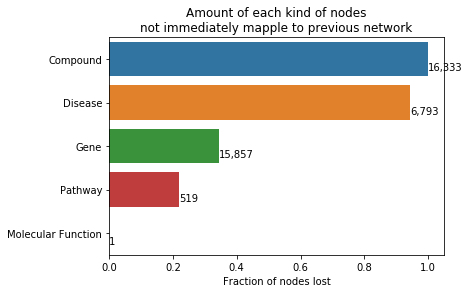

In [156]:
counts = nodes_filt.query('id not in @prev_ids')['label'].value_counts()
ratios = (counts / nodes_filt['label'].value_counts()).dropna()

count_plot_h(ratios, counts)
plt.xlabel('Fraction of nodes lost')
plt.title('Amount of each kind of nodes\nnot immediately mapple to previous network');

Diseases and Compounds are in different ID space (MESH), so its not surprising we'll lose a lot of them.  Also, Genes include a lot of organisms like Mice and Rats that we're not interested in, so not surprused a fair perfencate will be lost

In [157]:
from data_tools.wiki import get_curi_xrefs

In [158]:
mesh_to_nw = get_curi_xrefs(prev_nodes, 'MESH')

mesh_to_nw_map = nodes.merge(mesh_to_nw.rename(columns={'id': 'new_id'}), how='inner', left_on='id', right_on='xrefs')[['xrefs', 'new_id']]
mesh_to_nw_map.head(3)

,xrefs,new_id
0,MESH:D000759,MESH:D000759
1,MESH:D000373,MESH:D000373
2,MESH:D000521,NCBIGene:5443


In [159]:
nodes_reid = gt.re_id_nodes(nodes_filt, mesh_to_nw_map, 'xrefs', 'new_id', new_first=False)

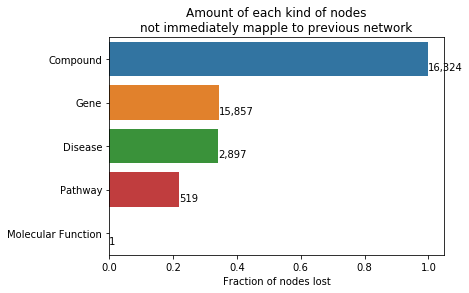

In [160]:
counts = nodes_reid.query('id not in @prev_ids')['label'].value_counts()
ratios = (counts / nodes_reid['label'].value_counts()).dropna()

count_plot_h(ratios, counts)
plt.xlabel('Fraction of nodes lost')
plt.title('Amount of each kind of nodes\nnot immediately mapple to previous network');

### Use string matching, as identifier cross-references failed to produce many hits

In [161]:
comps_to_remap = nodes_reid.query('id not in @prev_ids and label == "Compound"').copy()

In [162]:
comps_to_remap['name_id'] = comps_to_remap['name'].str.lower().apply(strip_chars)

In [163]:
comp_to_nw_map = comps_to_remap.merge(cid_map, left_on='name_id', right_on='old_id', how='inner')[['id', 'new_id']]
len(comp_to_nw_map)

9205

In [164]:
comp_to_nw_map.head(2)

,id,new_id
0,MESH:C000081,IKEY:LJQBMYDFWFGESC-IONNQARKSA-N
1,MESH:C000121,CHEBI:135483


In [165]:
mesh_to_nw_map.head(2)

,xrefs,new_id
0,MESH:D000759,MESH:D000759
1,MESH:D000373,MESH:D000373


In [166]:
final_map = pd.concat([mesh_to_nw_map.rename(columns={'xrefs': 'id'}), comp_to_nw_map], sort=False, ignore_index=True)
nodes_reid = gt.re_id_nodes(nodes_filt, final_map, 'id', 'new_id', new_first=False)

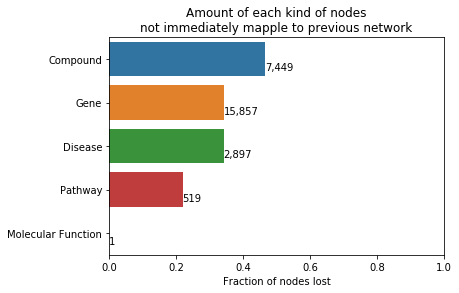

In [167]:
counts = nodes_reid.query('id not in @prev_ids')['label'].value_counts()
ratios = (counts / nodes_reid['label'].value_counts()).dropna()

count_plot_h(ratios, counts)
plt.xlim([0, 1])
plt.xlabel('Fraction of nodes lost')
plt.title('Amount of each kind of nodes\nnot immediately mapple to previous network');

In [168]:
# Get the nodes that are in the network so we can add xrefs
new_nodes = nodes_reid.query('id in @prev_ids and label in {!r}'.format(['Compound', 'Disease']))

# Add in any new compounds or diseases for a more complete network
# Also want to keep the kegg pathways as they contain new useful info
qr = nodes_reid.query('id not in @prev_ids and label in {!r}'.format(['Compound', 'Disease', 'Pathway']))
new_nodes = pd.concat([new_nodes, qr], sort=False, ignore_index=True)

# Combine new with old nodes, and update the xrefs
nodes_out = pd.concat([prev_nodes, new_nodes[['id', 'name', 'label', 'xrefs']]], sort=False, ignore_index=True)
nodes_out = pr.combine_group_cols_on_char(nodes_out, ['id'], ['xrefs'], sort=True, prog=False)

### Map edge ids

In [169]:
node_ids = nodes_out['id'].unique()
len(node_ids)

795304

In [170]:
edges_reid = gt.re_id_edges(edges, final_map)
print('{:,}'.format(len(edges_reid)))

7,200,598


In [171]:
print('CTD Edges: {:,}'.format(len(edges)))
print('CTD Edges mappable to prev NW nodes: {:,}'.format(len(edges_reid.query('start_id in @node_ids and end_id in @node_ids')
)))

CTD Edges: 5,354,828
CTD Edges mappable to prev NW nodes: 6,921,647


In [172]:
edges_reid.sample(10)

,start_id,end_id,type,parent_ixn,pub_med_ids,organism_id,source,dsrc_type,license,direct_evidence,p_val,adj_p,comp_type,inference_gene_symbol
5395380,GO:1903573,DOID:10545,associated_with,NaN,NaN,NaN,CTD,computed,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,inference,NaN
826659,MESH:D045506,REACT:R-HSA-187037,associated_with,NaN,NaN,NaN,CTD,computed,http://ctdbase.org/about/legal.jsp,NaN,4.540000e-57,9.630000e-54,hypergeometric,NaN
3447191,HP:0003251,REACT:R-HSA-375281,associated_with,NaN,NaN,NaN,CTD,computed,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,inference,FSHB
5992434,GO:0050766,DOID:60172,associated_with,NaN,NaN,NaN,CTD,computed,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,inference,NaN
3351187,MONDO:0024550,KEGG:hsa04064,associated_with,NaN,NaN,NaN,CTD,computed,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,inference,MAP3K7
2221566,CHEBI:45716,NCBIGene:26512,increases_expression,increases^expression,27188386,NCBITaxon:9606,CTD,curated,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,NaN,NaN
2704988,CHEBI:48861,KEGG:hsa04722,associated_with,NaN,NaN,NaN,CTD,computed,http://ctdbase.org/about/legal.jsp,NaN,7.920000e-12,6.530000e-09,hypergeometric,NaN
4838976,GO:0043966,DOID:60052,associated_with,NaN,NaN,NaN,CTD,computed,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,inference,NaN
4568991,GO:0097484,HP:0012125,associated_with,NaN,NaN,NaN,CTD,computed,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,inference,NaN
5438464,GO:0061045,DOID:9296,associated_with,NaN,NaN,NaN,CTD,computed,http://ctdbase.org/about/legal.jsp,NaN,NaN,NaN,inference,NaN


Went from only 420 mappable compound edges to 1,175,931

# Saving it out

In [173]:
prev_edges.head(2)

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,support_type,pmids,phase,date
0,UNII:BTY153760O,NCBIGene:3605,Neutralizing antibody,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
1,CHEBI:10055,NCBIGene:153,agonist,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN


In [174]:
keep_edge_col = ['start_id', 'end_id', 'type', 'pub_med_ids', 'source', 'dsrc_type', 'license', 'p_val', 'adj_p']

edges_out = pd.concat([prev_edges, 
                       edges_reid.query('start_id in @node_ids and end_id in @node_ids')[keep_edge_col].rename(columns={'pub_med_ids': 'pmids'})],
                       sort=False, ignore_index=True)

In [175]:
len(edges_out)

10769300

In [176]:
edges_out = pr.combine_group_cols_on_char(edges_out, ['start_id', 'end_id', 'type'], sort=True)
print(len(edges_out))

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel




10042751


In [177]:
edge_ids = edges_out[['start_id', 'end_id']].stack().unique()

In [178]:
edges_out.query('start_id not in @node_ids or end_id not in @node_ids')

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,support_type,pmids,phase,date


In [179]:
nodes_out_filt = nodes_out.query('id in @edge_ids')
len(nodes_out), len(nodes_out_filt)

(795304, 404610)

In [180]:
this_name = '08_CTD'
out_dir = Path('../2_pipeline/').joinpath(this_name).joinpath('out')
out_dir.mkdir(parents=True, exist_ok=True)

In [181]:
nodes_out.to_csv(out_dir.joinpath('nodes.csv'), index=False)
nodes_out_filt.to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)

edges_out.to_csv(out_dir.joinpath('edges.csv'), index=False)

# Metaedge Semmantics

Right now we have a ton of metaedges with lots of different semmantics connecting them.  We will look at these and look at how we can reduce the the total number, manually, then implement the changes computationally with a mapping file

In [182]:
combo = gt.combine_nodes_and_edges(nodes_out_filt, edges_out)

In [183]:
meta_edges = combo[['start_label', 'type', 'end_label']].copy()
meta_edges['meta_edge'] = meta_edges['start_label'] + ' - ' + meta_edges['type'] + ' - ' + meta_edges['end_label']
meta_edges['meta_edge'].value_counts()

Biological Process - associated_with - Disease               1775283
Biological Process - associated_with - Phenotype             1099289
Compound - associated_with - Pathway                          978994
Biological Process - only_in_taxon - Taxon                    551003
Cellular Component - only_in_taxon - Taxon                    412287
                                                              ...   
Biological Process - results_in_transport_along - Anatomy          1
Anatomy - positively_regulates - Biological Process                1
Compound - other - Gene                                            1
Drug - interacts - Cellular Component                              1
Compound - protein-protein interaction inhibitor - Gene            1
Name: meta_edge, Length: 574, dtype: int64

In [184]:
me_counts = meta_edges['meta_edge'].value_counts().to_dict()
meta_edges = meta_edges.drop_duplicates()
meta_edges['counts'] = meta_edges['meta_edge'].map(me_counts)
meta_edges = meta_edges.drop(['meta_edge'], axis=1)
meta_edges = meta_edges.sort_values(['start_label', 'end_label', 'counts'], ascending=[True, True, False])
meta_edges.to_csv(out_dir.joinpath('meta_edges.csv'), index=False)

In [185]:
meta_edges

,start_label,type,end_label,counts
1895965,Anatomy,capable_of,Biological Process,123.0
1895964,Anatomy,capable_of_part_of,Biological Process,121.0
1896023,Anatomy,contains_process,Biological Process,27.0
1895999,Anatomy,output_of,Biological Process,18.0
1896091,Anatomy,site_of,Biological Process,13.0
...,...,...,...,...
388794,Reaction,has_input,Protein,15404.0
378426,Reaction,follows_in_sequence,Reaction,10363.0
207474,Reaction,disrupts,Reaction,351.0
557589,Reaction,in_taxon,Taxon,5239.0
